In [ ]:
# Librerias para metodos numericos
import numpy as np
from scipy.sparse import diags, kron, csr_matrix, csc_matrix,bmat, coo_matrix, linalg
from scipy.sparse.linalg import spsolve, norm, inv, eigsh
import pandas as pd
# Librerias graficas
import matplotlib.pyplot as plt
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sb
rc('text', usetex=False) # para usar latex en matplotlib
# Estilo de las figuras
sb.set_theme(style="darkgrid")
sb.set_palette('tab10')
# rc('text', usetex=True) # para usar latex en matplotlib

*Universidad de Chile*  
*Facultad de Ciencias Físicas y Matemáticas*  
*Departamento de Ingeniería Matemática*

**MA5307-1 Análisis Numérico de EDP: Teoría y Laboratorio**  
**Profesor:** Axel Osses  
**Auxiliares:** Emir Chacra  
**Integrantes:** Manuel Torres $\&$ Mariano Vazquez $\&$ Rodrigo Fuentes.

# Laboratorio 1

El objetivo de esta sesión práctica es aprender a resolver EDP’s en 2
dimensiones mediante el Método de las Diferencias Finitas.

Específicamente se resolverá la ecuación de Poisson en un rectángulo unitario y en un dominio perforado, además se estudiará la aproximación para condiciones de borde en dominios con curvatura

# Parte a


## Ecuación de Poisson

Considere la ecuación dada por

$$
\begin{equation}
\left.
\begin{array}[c]{rll}
-\Delta u= & 0 & \text{sobre }\Omega=\left[  0,1\right]^{2}\\
u(0,y)=u(1,y)= & 0 & \text{en }0\leq y\leq 1\\
u(x,0)= & 0 & \text{en }0\leq x\leq 1\\
u(x,1)= & g(x) & \text{en }0\leq x\leq 1
\end{array}
\right\} \quad (1)
\end{equation}
$$

Sea $N\in\mathbb{N}$, considere la aproximación del cuadrado unitario dado por la malla de puntos
$$
\Omega_{h}=\left\{  \left(  x_{j},y_{k}\right)  \mid j,k\in\left\{
0,1,\ldots,N+1\right\}  \right\}
$$
donde $x_{j}=jh$, $y_{k}=kh$, $h=\dfrac{1}{N+1}$. Se define el operador laplaciano discretizado por 5 puntos como
$$
\Delta_{N}u_{j,k}=\dfrac{1}{h^{2}}\left(  u_{j+1,k}+u_{j-1,k}
+  u_{j,k-1}+u_{j,k+1}
-4u_{jk}\right)
$$
donde $u_{jk}$ aproxima a $u\left(x_{j},y_{k}\right)  $.

Tomando $g(x) = \sin(\pi x)$, se puede demostrar que la solución única de esta ecuación está dada por

$$u\left(  x,y\right)  =\frac{\sin\left( \pi x\right)   \sinh\left( \pi y\right)  }{\sinh\left(  \pi\right) } $$

**P1.** Escriba dos funciones que calculen $\boldsymbol{A}_{h}$ y $\boldsymbol{b}_{h}$ de la forma más simple posible. Las entradas para estas funciones deben ser $N$ y $g$.

También escriba una función `solve` que, utilizando estas funciones (y las funciones auxiliares que necesite), entregue la solución aproximada.

**Indicación.** Revise la documentación del comando `kron` (disponible a través de `scypy.sparse`)

In [ ]:
def Ah(N):
    """=========================================================================
    Input:          Recibe N que es el tamaño d
    Output:         Entrega la matriz Ah en formato sparse
    Descripcion:
    ========================================================================="""
    # Definicion del paso
    h = 1/(N+1)
    "Bloques L4 de identidad" 
    # Matriz L_4
    diagonales_L4   = [[4]*N,[-1]*(N-1),[-1]*(N-1)]
    L4              = diags(diagonales_L4, [0, -1, 1])
    # Matriz identidad
    diagonales_I    = [[1]*(N)]    # Diagonal de largo N
    I               = diags(diagonales_I, [0])
    "Posiciones de los bloques"
    # Matrices identidad y menos identidad para hacer los bloques
    diagonales_menosI   = [[-1]*(N-1)] # Diagonal superior e inferior de -1s 
    # Posiciones de los bloques en Ah (se usa en el producto de Kronecker)
    diag_central    = diags(diagonales_I,[0])
    diag_superior   = diags(diagonales_menosI,[1])
    diag_inferior   = diags(diagonales_menosI,[-1])
    "Producto de Kronecker"
    # Producto de Kronecker para las diagonales de bloques
    Ah0 = kron(diag_central,L4) 
    Ah1 = kron(diag_superior,I) 
    Ah2 = kron(diag_inferior,I)
    # Suma de las 3 diagonales de interes
    Ah = Ah0+Ah1+Ah2
    # output = ((1/h)**2)*(Ah)
    output = Ah
    return output
def bh(N,f,g):
    """=========================================================================
    Input: Funciones f,g
    Output: 
    Descripcion:
    ========================================================================="""
    # Definicion del paso
    h = 1/(N+1)
    "Llenado del arreglo bh"
    # Lista vacia para guardar b
    b = []
    # Llenado de la lista b
    for i in range(N):
        for j in range(N):
            if j != N-1: 
                # En este caso g es nulo
                f_ij = f((i+1)*h,(j+1)*h)
                h_ij = f_ij
                b.append(h_ij)
            else:
                # En este caso se suma un termino dependiente de h
                f_ij = f((i+1)*h,(j+1)*h)
                g_ij = g((i+1)*h)
                h_ij = f_ij + g_ij/(h**2)
                b.append(h_ij)
    output = np.array(b)
    return output
def solve(N, f, g):
    """=========================================================================
    Input:
    Output:
    Descripcion: Resuelve el problema del laplaciano en 2D en (0,1)^2, con 
    condiciones Dirichlet en el borde, usando una grilla uniforme, con tamano 
    de paso h=1/N en x e y. 
    ========================================================================="""    
    A = Ah(N)
    b = bh(N,f,g)
    output = spsolve(A,b)
    return output

Tests de los métodos *Ah* y *bh* 

In [ ]:
# Test del metodo Ah()
np.shape(Ah(3).toarray())
print(Ah(3).toarray())

[[ 4. -1.  0. -1.  0.  0.  0.  0.  0.]
 [-1.  4. -1.  0. -1.  0.  0.  0.  0.]
 [ 0. -1.  4.  0.  0. -1.  0.  0.  0.]
 [-1.  0.  0.  4. -1.  0. -1.  0.  0.]
 [ 0. -1.  0. -1.  4. -1.  0. -1.  0.]
 [ 0.  0. -1.  0. -1.  4.  0.  0. -1.]
 [ 0.  0.  0. -1.  0.  0.  4. -1.  0.]
 [ 0.  0.  0.  0. -1.  0. -1.  4. -1.]
 [ 0.  0.  0.  0.  0. -1.  0. -1.  4.]]


**P2.** Resuelva la ecuación para $N = 10, 20, 30, 40, 50$. Comente sus resultados.

In [ ]:
# Funciones f y g para testear los metodos de la pregunta 1
funcion_f = lambda x,y : 0              # Funcion f nula
funcion_g = lambda x : np.sin(x*np.pi)  # Funcion g del enunciado

In [ ]:
# Test del metodo solve para las funcion_f y funcion_g dadas
solve(10, funcion_f, funcion_g)         # Solucion usando f y g como condiciones

array([ 0.86683816,  1.80390239,  2.88710807,  4.20421007,  5.86191216,
        7.99451152, 10.77477866, 14.42795428, 19.24999695, 25.63155989,
        1.66345025,  3.46166334,  5.54031981,  8.06782004, 11.24892706,
       15.34135526, 20.67664883, 27.68704151, 36.94047363, 49.18660324,
        2.32529949,  4.83898091,  7.74468779, 11.27782321, 15.72462079,
       21.44533364, 28.90341988, 38.7030893 , 51.63825283, 68.75684051,
        2.79876679,  5.82427303,  9.32162722, 13.57416422, 18.92639927,
       25.81193863, 34.78860774, 46.58364297, 62.1526079 , 82.75680748,
        3.04549466,  6.33771718, 10.14338386, 14.77080717, 20.59487343,
       28.08741385, 37.85542951, 50.69026692, 67.6317283 , 90.05231008,
        3.04549466,  6.33771718, 10.14338386, 14.77080717, 20.59487343,
       28.08741385, 37.85542951, 50.69026692, 67.6317283 , 90.05231008,
        2.79876679,  5.82427303,  9.32162722, 13.57416422, 18.92639927,
       25.81193863, 34.78860774, 46.58364297, 62.1526079 , 82.75

In [ ]:
# Metodos auxiliares para el metodo graficar_solucion()
def asignar(solucion):
    """=========================================================================
    Input:          Solucion de la forma solve(N,f,g)
    Output:         Funcion lambda k,j : solve(N,f,g)[k,j]
    Descripcion:    Recibe una solucion obtenida mediante el metodo solve y 
    entrega dicha solucion como una funcion (k,j) \mapsto x(k,j).
    ========================================================================="""
    output = lambda k,j : solucion[k,j]
    return output
def solucion_con_cb(solucion, N, g, escala = 1):
    """=========================================================================
    Input: 
    Output: 
    Descripcion: 
    ========================================================================="""
    re_asignacion = np.reshape(solucion, (N, N))
    re_asignacion = re_asignacion*(1/np.max(re_asignacion))*escala
    "Matriz con condiciones de borde de tamaño (N+2)x(N+2)"
    # Asignamos los valores a una grilla de (N+2)x(N+2)
    matriz_con_cb = np.zeros((1,N))             # cb abrevia condiciones_borde
    matriz_con_cb = np.append(matriz_con_cb, re_asignacion, axis = 0)
    matriz_con_cb = np.append(matriz_con_cb, np.zeros((1,N)), axis = 0)
    matriz_con_cb = np.append(np.zeros((N+2,1)), matriz_con_cb, axis = 1)
    # Asignamos los valores al borde correspondiente a la funcion g
    g_borde         = np.array([[g(i) for i in np.linspace(0, 1, N+2, 
                                                           endpoint = True)]])
    g_borde         = np.reshape(g_borde, (N+2,1))  # Reescalar la informacion
    matriz_con_cb   = np.append(matriz_con_cb, g_borde, axis = 1)
    # Output
    output = matriz_con_cb
    return output

In [ ]:
# Test del metodo asignar()
x = solve(10, funcion_f, funcion_g)
asignacion = asignar(x)
print(asignacion)

<function asignar.<locals>.<lambda> at 0x7fdf46b1c710>


In [ ]:
# Test del metodo solucion_con_cb()


In [ ]:
def graficar_solucion(N, f, g):
    """=========================================================================
    Input: Funciones f,g
    Output: 
    Descripcion:
    ========================================================================="""
    # Salto
    h = 1/(N+1)  
    # Solucion obtenida con el metodo solve()  
    solucion = solve(N,f,g)
    "Grilla de (N+2)x(N+2) con interior de NxN" 
    # Division con linspace
    x_linspace = np.linspace(0, 1, N+2, endpoint = True)
    y_linspace = np.linspace(0, 1, N+2, endpoint = True)
    # Argumentos de ax.plot_surface
    arg_x , arg_y = np.meshgrid(np.array(range(N+2)), 
                                np.array(range(N+2)), indexing = 'ij')
    # Grilla (x,y)
    x, y    = np.meshgrid(x_linspace, y_linspace, indexing = "ij")
    z       = (asignar(solucion_con_cb(solucion, N, g, 1)))(arg_x, arg_y)
    "Generar figura 3D para representar la solucion"
    # Declaracion de la figura con su tamaño
    figura = plt.figure(figsize = (16,9))
    # Declaracion de ax en 3D
    ax = Axes3D(figura)
    ax.plot_surface(x, y, z, alpha = 0.8, cmap = 'jet')        
    ax.set_proj_type('ortho')                   # Angulo para observar la figura
    plt.show()

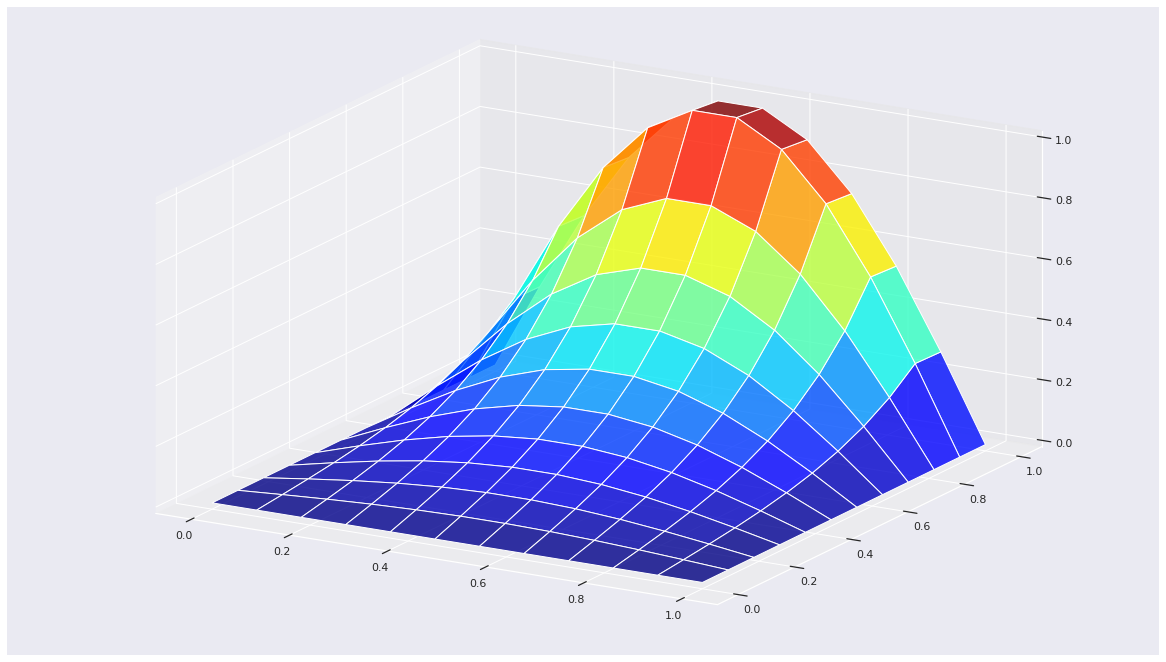

In [ ]:
# Test del metodo graficar_solucion()
graficar_solucion(10, funcion_f, funcion_g)

In [1]:
def x_con_cb(x, N, g, esc):
    x_cuad = np.reshape(x, (N, N))
    print('Escalamiento:', 1/np.max(x_cuad))
    x_cuad  = x_cuad * (1/np.max(x_cuad)) * esc
    x_cb    = np.append(np.zeros((1,N)), x_cuad, axis=0)
    x_cb    = np.append(x_cb, np.zeros((1,N)), axis=0)
    x_cb    = np.append(np.zeros((N+2,1)), x_cb, axis=1)
    g_borde = np.array([[g(punto) for punto in np.linspace(0, 1, N+2, 
                                                           endpoint=True)]])
    g_borde = np.reshape(g_borde, (N+2,1))
    x_cb    = np.append(x_cb, g_borde, axis=1)
    return x_cb
def asig(x):
    # f=0
    asignacion = lambda k,j : x[k,j] 
    return asignacion
def graficar_A(N,f,g):
    x = solve(N,f,g)
    h = 1/(N+1)
    xx = np.linspace(0, 1, N+2, endpoint=True)  
    yy = np.linspace(0, 1, N+2, endpoint=True) 
    #Ahora definimos una grilla.
    X, Y      = np.meshgrid(np.array(range(N+2)),
                            np.array(range(N+2)), indexing= 'ij')
    X_0, Y_0  = np.meshgrid(xx, yy, indexing= 'ij')
    # Y en este caso la matriz con la función evaluada.
    Z = (asig(x_con_cb(x,N,g,1)))(X,Y)
    ## Ahora, podemos utilizar gráficos de superficie
    fig = plt.figure(figsize = (16,9))
    ax = Axes3D(fig)
    ax.plot_surface(X_0, Y_0, Z, alpha= 0.8, cmap='jet')
    ax.set_proj_type('ortho') #Ángulo en que se mira el gráfico
    plt.title(f'Solución app. de $u_h(x,y)$, para N={N}', 
              fontsize=20)
    plt.xlabel('Eje x', fontsize=20)
    plt.ylabel('Eje y', fontsize=20)
    plt.show()
# Funciones f y g para testear los metodos de la pregunta 1
f = lambda x,y : 0              # Funcion f nula
g = lambda x : np.sin(x*np.pi)  # Funcion g del enunciado
for N in [10,20,30,40,50]:
    graficar_A(N, f, g)

NameError: ignored

La solución viene dada por la función
\begin{equation}
    u(x,y) = \frac{\sin(\pi x) \sinh(\pi y)}{\sinh(\pi)},
\end{equation}
a continuación testearemos la calidad de la solución obtenida mediante el método numérico implementado. Para ello graficamos la solución teórica para cada $N\in\{10,20,30,40,50\}$.

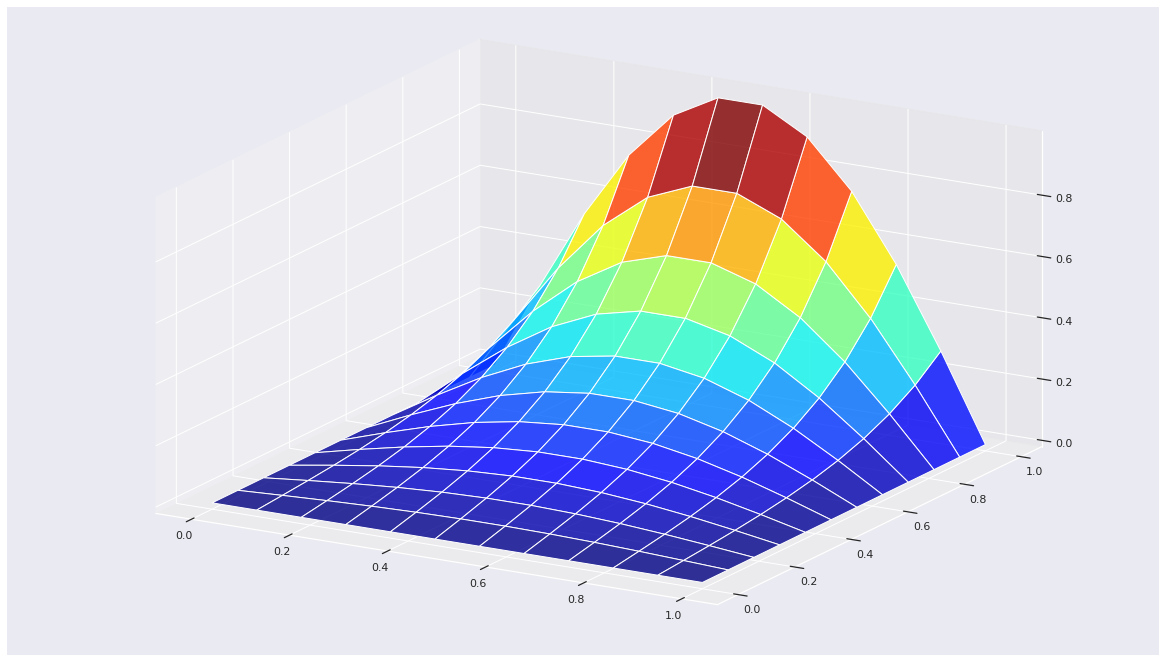

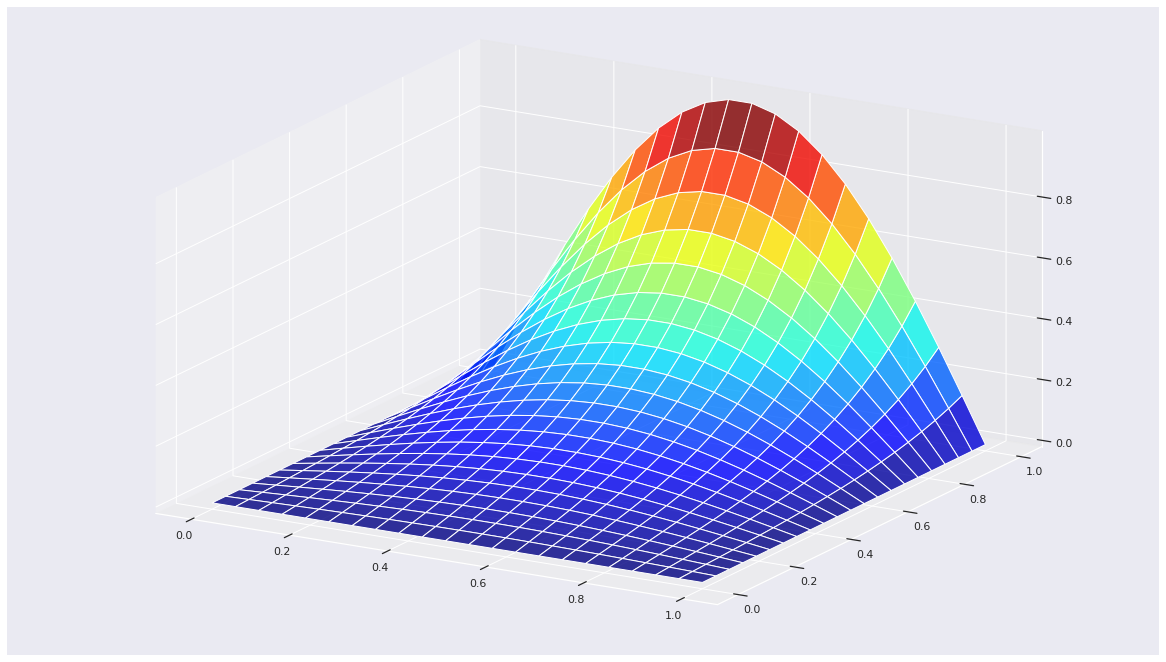

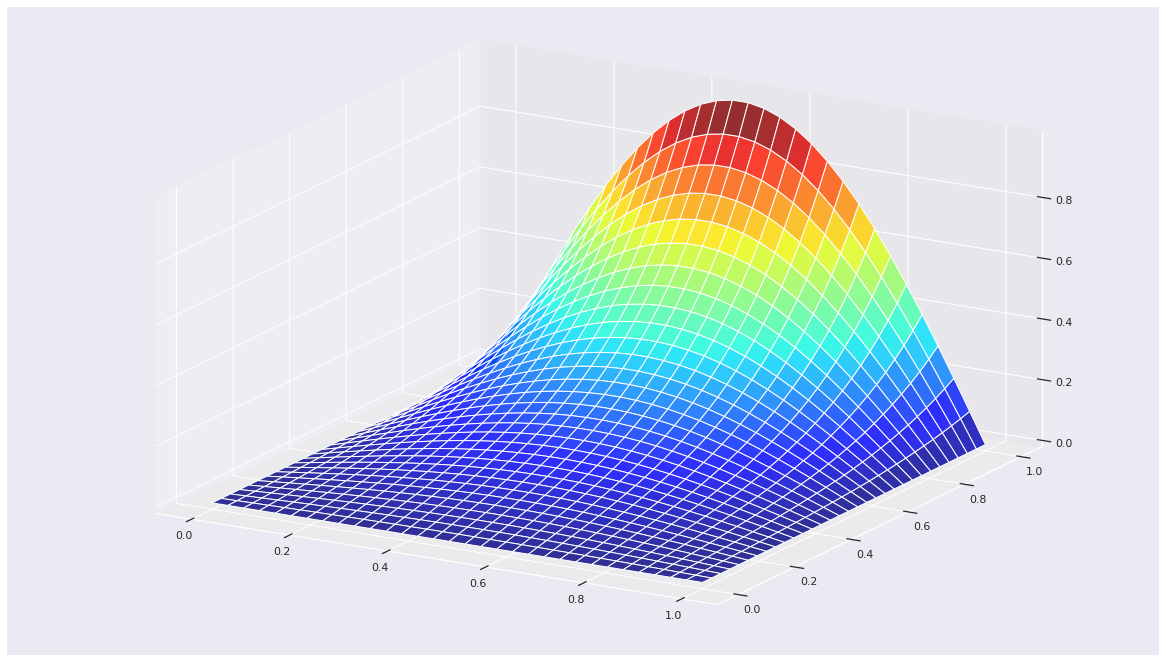

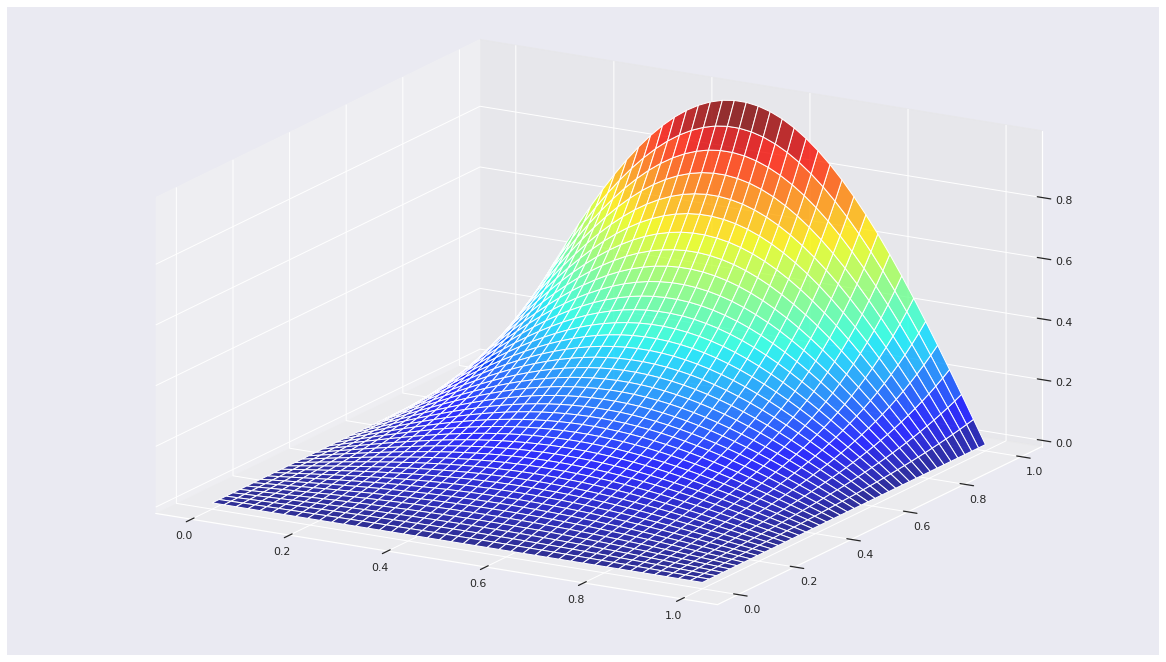

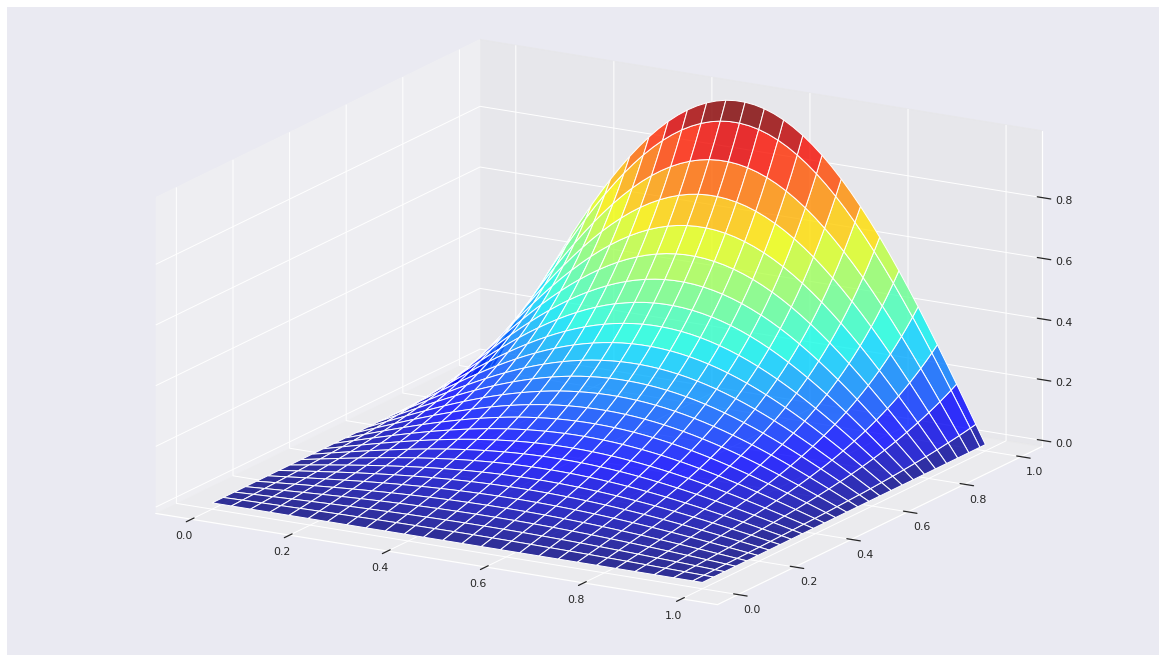

In [ ]:
# Test de la calidad de la solucion obtenida
u_real = lambda x,y : (np.sin(np.pi * x)*np.sinh(np.pi * y))/ np.sinh(np.pi) 

for N in [10,20,30,40,50]:
    h = 1/(N+1)
    xx = np.linspace(0, 1, N+2, endpoint=True)  
    yy = np.linspace(0, 1, N+2, endpoint=True) 
    # Ahora definimos una grilla.
    X, Y = np.meshgrid(xx,yy, indexing= 'ij')
    # Z en este caso la matriz con la función evaluada.
    Z = u_real(X,Y)
    ## Ahora, podemos utilizar gráficos de superficie
    fig = plt.figure(figsize=(16,9))
    ax = Axes3D(fig)
    ax.plot_surface(X, Y, Z, alpha= 0.8, cmap='jet')
    ax.set_proj_type('ortho') #Ángulo en que se mira el gráfico
    plt.show()

**P3.** Estudie el condicionamiento en norma $2$ de la Matriz $A_h$.

**Indicación.** Sean $p\in\left[  1,+\infty\right]  $ y $\boldsymbol{A}\in\mathbb{R}^{N\times N}$. Se define la norma inducida $p$ de $\boldsymbol{A}$ como
$$
\left\Vert \boldsymbol{A}\right\Vert _{p}=\sup\limits_{\boldsymbol{x\in}\mathbb{R}^{N}\setminus\left\{  \boldsymbol{0}\right\}  }\dfrac{\left\Vert\boldsymbol{Ax}\right\Vert _{p}}{\left\Vert \boldsymbol{x}\right\Vert_{p}}
$$
y, si $\boldsymbol{A}$ es invertible, el número de condición en norma inducida $p$ como $\operatorname{cond}_{p}\left(  \boldsymbol{A}\right)  =\left\Vert
\boldsymbol{A}\right\Vert _{p}\left\Vert \boldsymbol{A}^{-1}\right\Vert _{p}$.

En este caso particular, como $\boldsymbol{A}_{h}$ es simétrica, el número de condición en la norma $2$ inducida puede calcularse como
$$
\operatorname{cond}_{2}\left(  \boldsymbol{A}_{h}\right)  =\dfrac{\lambda_{\max,h}\left(  \boldsymbol{A}_{h}\right)  }{\lambda_{\min,h}\left(\boldsymbol{A}_{h}\right)}
$$
donde $\lambda_{\max,h}\left(  \boldsymbol{A}_{h}\right)  =\max\left\{\left\vert \lambda\right\vert \mid\lambda\in\sigma\left(  \boldsymbol{A}_{h}\right)  \right\}  $ y $\lambda_{\min,h}\left(  \boldsymbol{A}_{h}\right)
=\min\left\{  \left\vert \lambda\right\vert \mid\lambda\in\sigma\left(\boldsymbol{A}_{h}\right)  \right\}  $.

In [ ]:
def cond_2_sparse(A):
    """
    Calcula el numero de condicionamiento en norma inducida 2
    para una matriz sparse simetrica A.
    Se obtiene como el valor propio de mayor módulo dividido por el de menor módulo
    
    Input:
    - A matriz sparse simetrica
    
    Documentacion de eigsh:
    https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.sparse.linalg.eigsh.html
    """
    vals, _ = eigsh(A.toarray(), k=A.shape[0])
    min_value, max_value = (np.min(np.abs(vals)), np.max(np.abs(vals)))  
    cond = max_value/min_value
    output = cond
    return output

In [ ]:
cond_2_sparse(Ah(10))

/usr/local/lib/python3.7/dist-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1592: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  RuntimeWarning)


48.37415007870754

/usr/local/lib/python3.7/dist-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1592: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  RuntimeWarning)


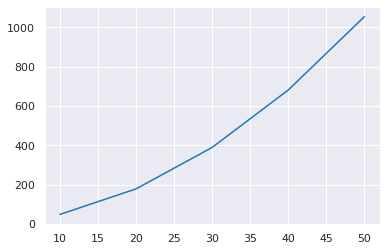

In [ ]:
plt.plot(range(10,60,10), [cond_2_sparse(Ah(N)) for N in range(10,60,10)])
plt.show()

# Parte b

## Ecuación en Dominios Perforados

Para $\Omega = [0, 1]^2\backslash B ((0.5, 0.5), 0.3)$, considere:
$$
\left(  P \right)  \left\{
\begin{array}
[c]{ccc}
-\Delta u(x,y)=&0,  & \text{si }(x,y)\text{ en }\Omega \\
u(x,y)=&g(x,y), & \text{si} (x,y)\text{ en }\partial\Omega
\end{array}
\right.
$$

y $g$ dada por:

$$
g\left(  x,y\right)  =\left\{
\begin{array}
[c]{cc}
2  & \text{si }(x,y) \in \partial [0,1]^2 \\
0  & \text{si }(x,y) \in \partial B ((0.5, 0.5), 0.3)
\end{array}
\right.
$$






**P1.** Genere una función que reciba un punto de la malla $(x_j , y_k)$ y entregue como resultado $1$ si es un
punto interior al cual se le puede calcular $\Delta u$ con la aproximación utilizada en la fórmula de $5$ puntos.

In [ ]:
def pertenece(x,y):
    """
    Input       =   x,y corresponde a las coordenadas 
    Output      =   
    Descripcion =   
    """
    if ((x <= 1) and (y <= 1) and (x >= 0) and (y >= 0) and (
        ((x - 0.5)**2 + (y - 0.5)**2) >= (0.3**2))):
        return True 
    else:
        return False
def aproximable(x,y,N):
    """
    Input       =   x,y corresponde a las coordenadas 
    Output      =   
    Descripcion =   Funcion entrega si un punto (x,y) perteneciente al dominio 
    es aproximable mediante 5 puntos.
    """
    h = 1/(N+1)
    if (pertenece(x,y) and pertenece(x+h,y) and pertenece(x-h,y) and 
        pertenece(x,y+h) and pertenece(x,y-h)):
        return 1
    else:
        fallo_x, fallo_y = 0, 0
        for paso_x in [-1,1]:
            if not pertenece(x+(h*paso_x), y):
                fallo_x = paso_x
        for paso_y in [-1,1]:
            if not pertenece(x, y+(h*paso_y)):
                fallo_y = paso_y
    output = [fallo_x, fallo_y]
    return output
def distancia(x,y,N,sentido_x,sentido_y):
    """
    Input       =   x, y corresponde a las coordenadas.
                    sentido_x, sentido_y corresponde a 
                    N corresponde a
    Output      =   
    Descripcion =   
    """
    # Verificar inputs correctamente, ya que no tiene sentido que los inputs
    # dados por sentido_x y sentido_y sean valores fuera del set $\{0,1,-1\}
    valores = [-1, 0, 1]
    assert ((sentido_x in valores) and (sentido_y in valores) and
            (sentido_x == 0 or sentido_y == 0))
    # Metodo distancia
    h = 1/(N+1)
    if aproximable(x,y,N) == 1:
        return h
    else:
        [fallo_x, fallo_y] = aproximable(x,y,N)
        if sentido_y == 0:
            if fallo_x != sentido_x:
                return h
            else:
                return abs(min(0.5-x+np.sqrt(0.3**2-(y-0.5)**2),
                               0.5-x-np.sqrt(0.3**2-(y-0.5)**2)))
        else:
            if fallo_y != sentido_y:
                return h
            else:
                return abs(min(0.5-y+np.sqrt(0.3**2-(x-0.5)**2),
                               0.5-y-np.sqrt(0.3**2-(x-0.5)**2)))

In [ ]:
x,y         = 0.375,0.125
sentido_x   = 1
sentido_y   = 0
N           = 7
h           = 1/(N+1)
aproximable(x,y,N)
distancia(x,y,N,sentido_x,sentido_y)

0.125

**P2.** Asuma que la matriz del sistema es de la forma $A = A_x + A_y$, donde $A_x$ tiene los coeficientes adecuados
para la aproximación de la derivada parcial según $x$ y lo equivalente para $A_y$. Encuentre la forma
que deben tener $A_x$ y $A_y$ y escriba un programa que calcule dichas matrices.

In [ ]:
def sistema_borde(distancia,h):
    """
    Input       =   
    Output      =   
    Descripcion =   
    """
    A = np.array([
                  [1,1,1],
                  [h, 0, -np.abs(distancia)],
                  [(h**2)/2, 0, (np.abs(distancia)**2)/2]
                ]) 
    b = np.array([0,0,1]) 
    alpha, beta, gamma = spsolve(A,b)
    output = (alpha, beta, gamma) 
    return output
def Ahx(N):
    """
    Input       =   
    Output      =   
    Descripcion =   
    """
    h = 1/(N+1)
    # Definimos las diagonales necesarias para B1 y B2
    e = np.ones(N)
    f = np.ones(N-1)
    # Bloque B1         
    B1 = diags(np.array([-f, 2*e,-f], dtype = object),  # Lista de vectores
               [-1,0,1] )                               # Posiciones c/r la diag
    # Matriz Ahx mediante bloques
    k_Ahx = []
    for i in range(N):
        if i == 0:
            k_Ahx.append([B1] + [None]*(N-1))
        elif i == 1:
            k_Ahx.append([None] + [B1] + [None]*(N-2))
        elif i == N-1:
            k_Ahx.append([None]*(N-1) + [B1])
        elif i == N-2:
            k_Ahx.append([None]*(N-2) + [B1] + [None])
        else:
            k_Ahx.append([None]*i + [B1] + [None]*(N-i-1)) 
    Ax = bmat(k_Ahx, format = 'csc')
    for j in range(N):
        for k in range(N):
            if not pertenece((j+1)*h, (k+1)*h):
                Ax[j*N+k    , j*N+k] = 1
                Ax[j*N+k-1  , j*N+k] = 0
                Ax[j*N+k+1  , j*N+k] = 0
    for j in range(N):
        for k in range(N):
            if pertenece((j+1)*h, (k+1)*h):
                x_j = (j+1)*h
                y_k = (k+1)*h
                if aproximable(x_j,y_k,N) != 1:
                    # Se crea y resuelve el sistema de ecuaciones
                    sentido_x = aproximable(x_j,y_k,N)[0]
                    d = distancia(x_j,y_k,N,sentido_x,0)
                    if sentido_x == -1:
                        alpha, beta, gamma = sistema_borde(d,h)
                    else:
                        gamma, beta, alpha = sistema_borde(d,h)
                    # Cambiar elementos en la matriz principal
                    Ax[j*N+k, j*N+k] = -beta
                    Ax[j*N+k, j*N+k-sentido_x] = -alpha
                    Ax[j*N+k, j*N+k+sentido_x] = 0
    output = (1/h**2)*Ax
    return output
def Ahy(N):
    """
    Input       =   
    Output      =   
    Descripcion =   
    """
    h=1/(N+1)
    # Definicion de las diagonales para B1 y B2
    e = np.ones(N) 
    f = np.ones(N-1)
    # bloque B1
    B1 = np.identity(N)*2 # Definir matriz sparse diagonal
    # bloque B2 (identidad)
    B2 = -np.identity(N)  #diags(k_B2,offset_B2) # Definir matriz sparse diagonal
    # Matriz Ahy mediante bloques
    k_Ahy = []
    for i in range(N):
        if i == 0:
            k_Ahy.append([B1] + [B2] + [None]*(N-2))
        elif i == 1:
            k_Ahy.append([B2] + [B1] + [B2] + [None]*(N-3))
        elif i == N-1:
            k_Ahy.append([None]*(N-2) + [B2] + [B1])
        elif i == N-2:
            k_Ahy.append([None]*(N-3) + [B2] + [B1] + [B2])
        else:
            k_Ahy.append([None]*(i-1) + [B2] + [B1] + [B2] + [None]*(N-3-(i-1)))
            
    Ay = bmat(k_Ahy, format= 'csc')

    for j in range(N):
      for k in range(N):
        if not pertenece((j+1)*h,(k+1)*h):
          Ay[j*N+k, j*N+k]      = 1
          Ay[j*N+k, (j-1)*N+k]  = 0
          Ay[j*N+k, (j+1)*N+k]  = 0
          
    for j in range(N):
        for k in range(N):
            if pertenece((j+1)*h,(k+1)*h):
                x_j = (j+1)*h
                y_k = (k+1)*h
                if aproximable(x_j, y_k, N) != 1:
                    if aproximable(x_j, y_k, N)[1] != 0:
                        # Se crea y resuelve el sistema de ecuaciones
                        sentido_y = aproximable(x_j, y_k, N)[1]
                        d = distancia(x_j, y_k, N, 0, sentido_y) 
                        if sentido_y == -1:  
                            alpha, beta, gamma = sistema_borde(d,h)
                        else:
                            gamma, beta, alpha = sistema_borde(d,h)   
                        # Cambiar elementos en la matriz principal
                        Ay[j*N + k, j*N + k] = -beta
                        Ay[j*N + k, ((j- sentido_y)*N + k) ] = -alpha
                        Ay[j*N + k, ((j+ sentido_y)*N + k) ] = 0
    output = (1/h**2)*Ay
    return output

In [ ]:
# Test de Ahx
pd.DataFrame(Ahx(4).todense())

/usr/local/lib/python3.7/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:198: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,50.000000,-25.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,-13419.828529,14571.067812,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,0.000000,-13419.828529,14571.067812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,0.000000,0.000000,-25.000000,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.0,-25.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.0,0.0,0.0,25.0,-25.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,-25.0,25.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


In [ ]:
# Test de Ahy
pd.DataFrame(Ahy(4).todense())

/usr/local/lib/python3.7/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,50.000000,0.0,0.0,0.0,-25.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
1,0.000000,50.0,0.0,0.0,0.000000,-25.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,0.000000,0.0,50.0,0.0,0.000000,0.0,-25.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3,0.000000,0.0,0.0,50.0,0.000000,0.0,0.0,-25.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
4,-13419.828529,0.0,0.0,0.0,14571.067812,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
5,0.000000,0.0,0.0,0.0,0.000000,25.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
6,0.000000,0.0,0.0,0.0,0.000000,0.0,25.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
7,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,428.932188,0.000000,0.0,0.0,-319.348952,0.0,0.0,0.0,0.000000
8,0.000000,0.0,0.0,0.0,-13419.828529,0.0,0.0,0.000000,14571.067812,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
9,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,25.0,0.0,0.000000,0.0,0.0,0.0,0.000000


**P3.** Escriba una función que calcule $b_h$ adaptado a este caso.

In [ ]:
def bh(N):
    """
    Input       =   N que determina el tamaño de la grilla y la discretizacion
    Output      =   
    Descripcion =   Funcion que calcula bh adaptado al problema de dominios 
                    perforados
    """
    h = 1/(N+1)
    b = np.zeros(N**2)
    # casos y=0, y=1, x=0, x=1
    row = [i for i in range(N**2) if (i in range(N) or 
                                      i in range(N**2-N, N**2)) or
                                       (i%N==0 or i%N == (N-1))]
    col = [0 for i in row]
    data = [2 for i in row]
    # Caso especial de las esquinas (se necesita sumar dos veces 2)
    data[0] = 4
    data[N-1] = 4
    data[-1] = 4
    data[-N] = 4
    b_2 = csc_matrix((data, (row, col)), shape=(N**2, 1))
    output = (1/h**2)*b_2
    return output
def solve2(N):
    """
    Input       =   
    Output      =   
    Descripcion =   
    """
    A = Ahx(N) + Ahy(N)
    b = bh(N)
    output = spsolve(A,b)
    return output

**P4.** Resuelva el sistema y grafique la solución aproximada para $N = 10, 20, 30, 40, 50$. Comente sus resultados.

In [ ]:
g_problema_2 = lambda x : 2 
def graficar_A(N,g):
    """
    Input       =   
    Output      =   
    Descripcion =   Metodo que grafica la superficie de la solucion
    """
    x = solve2(N)
    h= 1/(N+1)
    xx = np.linspace(0, 1, N+2, endpoint=True)  
    yy = np.linspace(0, 1, N+2, endpoint=True)  
    # Grilla
    X, Y = np.meshgrid(np.array(range(N+2)),
                       np.array(range(N+2)), indexing= 'ij')
    X_0, Y_0 = np.meshgrid(xx, yy, indexing= 'ij')
    # Matriz con la funcion evaluada
    Z = (asignar(solucion_con_cb(x,N,g,2)))(X,Y)
    # Grafico de superficie (3D)
    fig     = plt.figure(figsize=(16,9))
    ax      = Axes3D(fig)
    ax.plot_surface(X_0, Y_0, Z, alpha= 0.8, cmap='jet')    # Superficie
    ax.set_proj_type('ortho')                               # Angulo de vision
    plt.title(f'Solución app. en dominios perforados de $u_h(x,y)$, para N={N}', 
              fontsize=20)
    plt.xlabel('Eje x', fontsize=20)
    plt.ylabel('Eje y', fontsize=20)
    plt.show()                                              # Mostrar figura

In [ ]:
# Respuesta
for N in [10,20,30,40,50]:
    graficar_A(N, g_problema_2)

Output hidden; open in https://colab.research.google.com to view.

**P5.** ¿Qué sucede con el condicionamiento de la matriz utilizando la fórmula de la Parte a?¿Cómo adaptaría su código para el caso $f\neq 0$?